In [1]:
# silly autoreload to avoid restarting the kernel every time
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from ekf_vindy.plotting import plotter
from ekf_vindy.ekf.utils import add_noise_with_snr
from ekf_vindy.vindy import torch_config
from scipy.integrate import odeint

seed = 29

# Setup torch device and dtype
torch_config.setup_device_and_type()
np.random.seed(seed)

/home/carlos/.cache/pypoetry/virtualenvs/vindy-MoRRIXoN-py3.11/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


LaTeX is installed. Using LaTeX for rendering.
PyTorch device set to cpu and dtype set to torch.float32.


# Sel'kov system with gradient-based SINDy (in PyTorch)

We just feed noiseless trajectories for different ICs of the Sel'kov ODE (representing glucose levels or something). The ODE that we use to generate the data is

$$
\begin{align}
    \dot{x}_1 &= \rho - \sigma_1 x_1 - \xi_1 x_1 x_2^2, \\
    \dot{x}_2 &= \sigma_2 x_1 - k_2 x_2 + \xi_2 x_1 x_2^2 .
\end{align}
$$

In [2]:
# Define Selkov system to be found with SINDy

def selkov(x, t, params):
    rho = params['rho']
    sigma1 = params['sigma1']
    sigma2 = params['sigma2']
    chi1 = params['chi1']
    k2 = params['k2']
    chi2 = params['chi2']
    
    x1 = x[0]
    x2 = x[1]
    
    dx1 = rho - sigma1 * x1 - chi1 * x1 * x2 ** 2
    dx2 = sigma2 * x1 - k2 * x2 + chi2 * x1 * x2 ** 2

    return [dx1, dx2]

Let's generate some noisy trajectories for different initial conditions, and subsequently optimize with gradient-optimized SINDy.

In [3]:
params = {
    'rho': 0.92,
    'sigma1': 0.10,  
    'sigma2': 0.10,
    'chi1': 1.0,  
    'k2': 1.0,    
    'chi2': 1.0,  
}

# Generate observations and cast them to appropriate torch tensors of shape (#datapoints, #time_instances, #dim)
dt = 0.01
n_train = 20
std = 0.5
mean_ic = np.array([0.05, 0.05])
x_0 = np.random.randn(n_train, 2) * std + mean_ic
time_instances = np.arange(0, 15, dt)
x_train = []

for i in range(n_train):
    sol = odeint(selkov, x_0[i, :], time_instances, args=(params,))
    x_train.append(sol)

model = ps.SINDy(feature_names=['u1', 'u2'],
                 feature_library=ps.PolynomialLibrary(degree=3),
                 optimizer=ps.STLSQ(threshold=5e-2))
model.fit(x_train, t=0.01, multiple_trajectories=True)
model.print()
    
x_train_np = np.stack(x_train, axis=0)     # shape: (n_train, T, 2)
x_train = torch.from_numpy(x_train_np).to(device = torch_config.device, dtype = torch_config.dtype)
x_train.shape

(u1)' = 0.920 1 + -0.100 u1 + -1.000 u1 u2^2
(u2)' = 0.100 u1 + -1.000 u2 + 1.000 u1 u2^2


torch.Size([20, 1500, 2])

We use one-sided finite differences to estimate the derivatives from data

In [4]:
dt = torch.tensor(dt, device=torch_config.device, dtype=torch_config.dtype)
# central
dxdt_mid = (x_train[:, 2:, :] - x_train[:, :-2, :]) / (2 * dt)

# forward difference for first point
dxdt_0 = (x_train[:, 1:2, :] - x_train[:, 0:1, :]) / dt

# backward difference for last point
dxdt_T = (x_train[:, -1:, :] - x_train[:, -2:-1, :]) / dt

# concatenate to get shape (N, T, 2)
dxdt = torch.cat([dxdt_0, dxdt_mid, dxdt_T], dim=1)

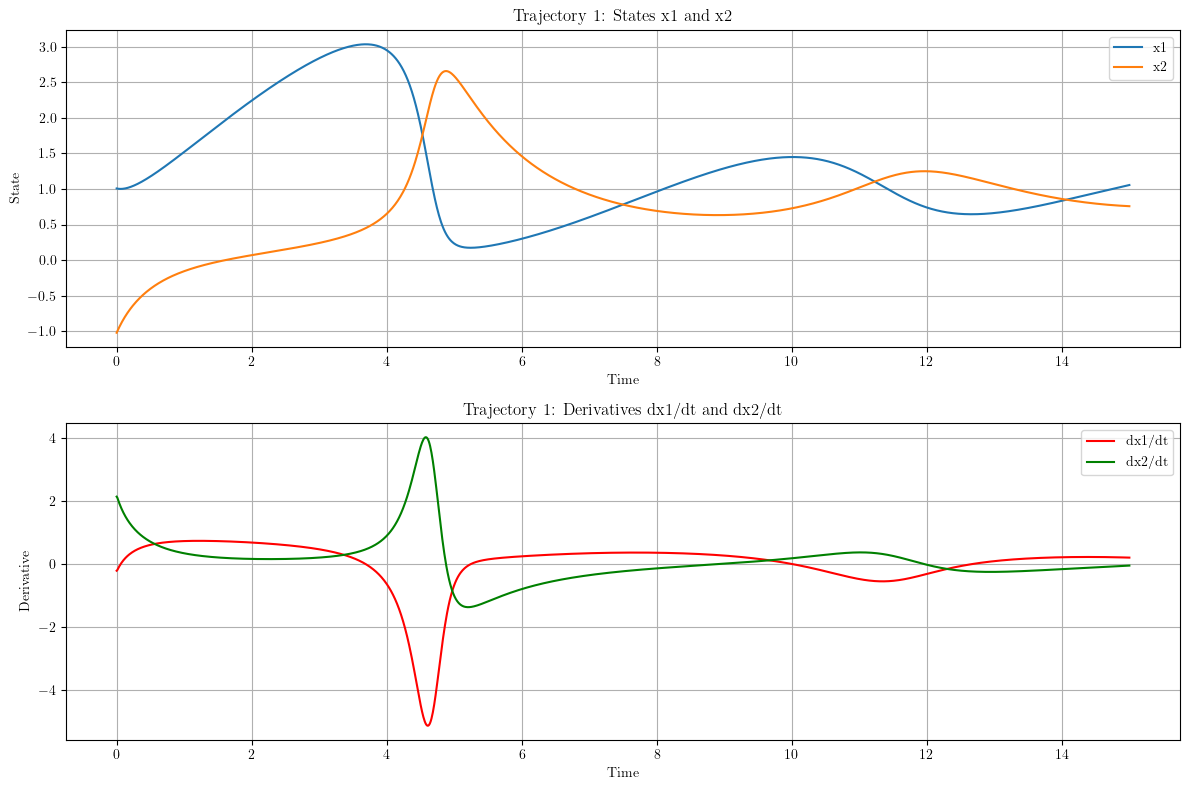

In [5]:
i = 1  # trajectory index

plt.figure(figsize=(12, 8))

# --- Plot x1 and x2 ---
plt.subplot(2, 1, 1)
plt.plot(time_instances, x_train[i, :, 0].cpu().numpy(), label='x1')
plt.plot(time_instances, x_train[i, :, 1].cpu().numpy(), label='x2')
plt.xlabel('Time')
plt.ylabel('State')
plt.title(f'Trajectory {i}: States x1 and x2')
plt.grid(True)
plt.legend()

# --- Plot dx1/dt and dx2/dt ---
plt.subplot(2, 1, 2)
plt.plot(time_instances, dxdt[i, :, 0].cpu().numpy(), color='r', label='dx1/dt')
plt.plot(time_instances, dxdt[i, :, 1].cpu().numpy(), color='g', label='dx2/dt')
plt.xlabel('Time')
plt.ylabel('Derivative')
plt.title(f'Trajectory {i}: Derivatives dx1/dt and dx2/dt')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

We have to pass this to the SINDy layer... so we need a training loop. Recall we must explicitly call the <code> _apply_mask() </code>, and we must apply L1 regularization.
Recall that the SINDy loss is:

$$
\mathcal{L}(\Xi)=\Big|\Big|\dot{\mathbf{Z}}-\boldsymbol{\Theta}(\mathbf{Z})\Xi\Big|\Big|^2_2 + \lambda ||\Xi||_1,
$$

where $\mathbf{Z},\dot{\mathbf{Z}} \in \mathbb{R}^{\text{batch}\times n}, \boldsymbol{\Theta}(\mathbf{Z})\in \mathbb{R}^{\text{batch}\times p}, \Xi \in \mathbb{R}^{p\times n}$. This may clash with standard SINDy notation, but we keep it consistent within our own framework and code. After each epoch, zero coefficients whose current value is below a certain threshold.

In [13]:
from ekf_vindy.vindy.layers.sindy_layer import SINDyLayer
from ekf_vindy.vindy.training_loops import train_sindy

N, T, n = x_train.shape

z_train = x_train.reshape(N*T, n)
dzdt_train = dxdt.reshape(N*T, n)

sindy_layer = SINDyLayer(latent_dim=n, n_parameters=0, poly_order=3, parameter_names=None, big_xi_initialization='ones',
                         prune_threshold=1e-2)
print(f'type of var_names: {type(sindy_layer.var_symbols[0])}')

# trained_layer = train_sindy(
#     sindy_layer,
#     z_train,
#     dzdt_train,
#     n_epochs=5000,
#     lr=1e-3,
#     l1_weight=1e-2,
#     warmup = 500,
#     pruning_epochs=500,
#     n_epochs_refinement=1000
# )

type of var_names: <class 'sympy.core.symbol.Symbol'>


In [ ]:
# print(trained_layer.big_xi)

Parameter containing:
tensor([[ 0.4362,  0.0000],
        [ 0.1795, -0.1073],
        [ 0.1865, -0.4019],
        [ 0.0769, -0.0000],
        [-0.0744,  0.0509],
        [ 0.0387,  0.0000],
        [-0.0000, -0.0000],
        [-0.3629,  0.2041],
        [-0.5109,  0.4558],
        [-0.0939, -0.0342]], requires_grad=True)


In [ ]:
# trained_layer.print_model()

(z_0)' = 0.436 1 + 0.179 z_0 + 0.186 z_1 + 0.0769 z_0^2 + -0.0744 z_0 z_1 + 0.0387 z_1^2 + -0.363 z_0^2 z_1 + -0.511 z_0 z_1^2 + -0.0939 z_1^3
(z_1)' = -0.107 z_0 + -0.402 z_1 + 0.0509 z_0 z_1 + 0.204 z_0^2 z_1 + 0.456 z_0 z_1^2 + -0.0342 z_1^3
